In [1]:
%load_ext autoreload
%autoreload 3

import modules.measures as measures
import modules.data_preparation as data_prep
import modules.constants as const
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import modules.statistics as stat
import seaborn as sns
import os

In [2]:
ADAPT_TO_MIO_OBJECTIVES = True

we now want to do the autocorrelation comparison for k = 1

k = 1
Number of random walks: 26000
Number of autocorrelation values for branch distance: 26000
Number of autocorrealtion values for code-based: 21149


<Figure size 640x480 with 0 Axes>

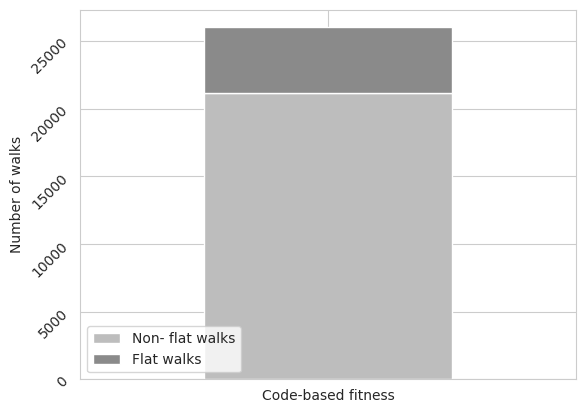

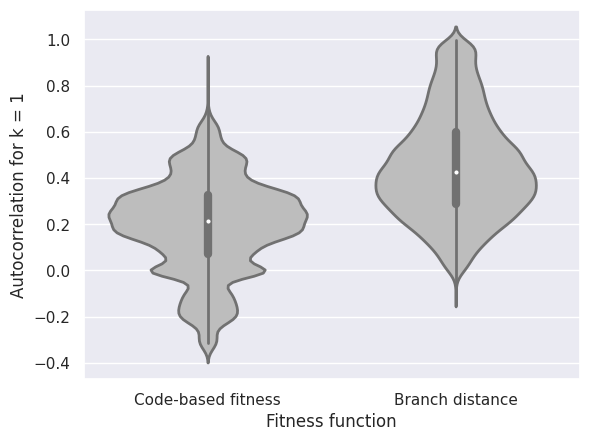

---------------------------------------------------------------------------------
k = 2
Number of random walks: 26000
Number of autocorrelation values for branch distance: 26000
Number of autocorrealtion values for code-based: 21149


<Figure size 640x480 with 0 Axes>

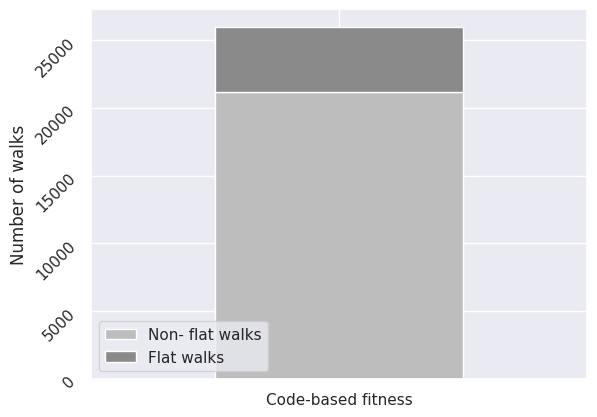

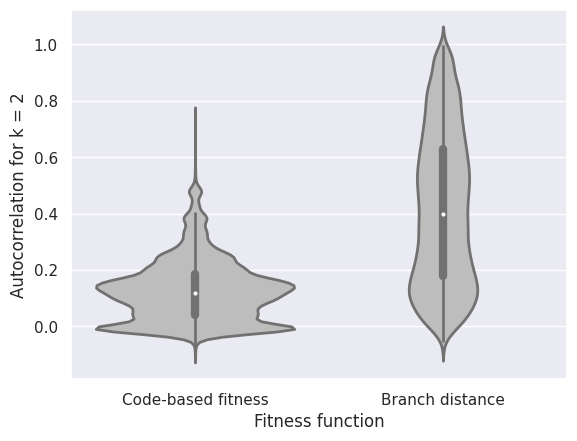

---------------------------------------------------------------------------------
k = 3
Number of random walks: 26000
Number of autocorrelation values for branch distance: 26000
Number of autocorrealtion values for code-based: 21149


<Figure size 640x480 with 0 Axes>

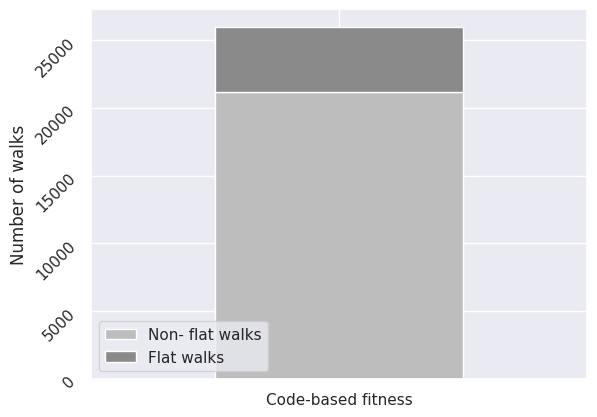

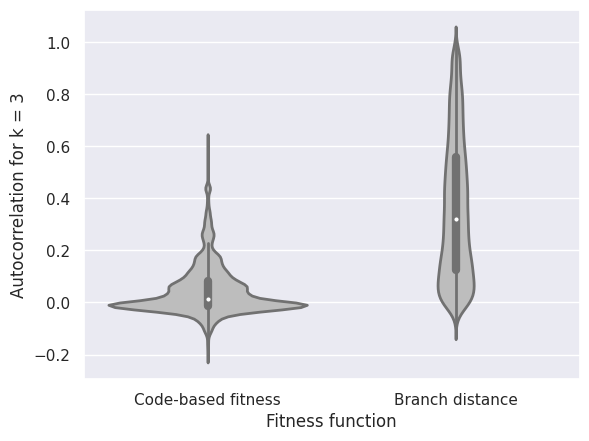

---------------------------------------------------------------------------------


In [3]:
iterations = 3

for k in range(1, iterations+1):
    print("k = " + str(k))

    autocorrelation_values = pd.read_csv("store2/autocorrelation" + str(k) + "_measure_df_with_objectives.csv")
    if ADAPT_TO_MIO_OBJECTIVES:
        autocorrelation_values = pd.merge(autocorrelation_values, data_prep.get_mio_runs()[const.OBJECTIVE].drop_duplicates(), on=const.OBJECTIVE)


    autocorrelation_values = autocorrelation_values.dropna()

    number_of_values_expected = 26000 if ADAPT_TO_MIO_OBJECTIVES else 52140
    number_of_values_code_based = len(autocorrelation_values.query("`" + str(const.FITNESS_FUNCTION) + "` == '" + str(const.CODE_BASED) + "'").index)
    number_of_values_branch_distance = len(autocorrelation_values.query("`" + str(const.FITNESS_FUNCTION) + "` == '" + str(const.BRANCH_DISTANCE) + "'").index)

    print("Number of random walks: " + str(number_of_values_expected))
    print("Number of autocorrelation values for branch distance: " + str(number_of_values_branch_distance))
    print("Number of autocorrealtion values for code-based: " + str(number_of_values_code_based))

    fig = plt.figure()

    barplot_data_dict = {"Non- flat walks": [number_of_values_code_based], "Flat walks": [number_of_values_expected - number_of_values_code_based]}
    barplot_data_df = pd.DataFrame(barplot_data_dict, index=[const.CODE_BASED])

    ax = barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', 'green'])
    sns.move_legend(ax, "lower left")
    plt.ylabel("Number of walks")
    plt.xticks(rotation=0)
    plt.yticks(rotation=45)
    plt.savefig(Path(const.DIAGRAM_OUT_PATH) / ("autocorrelation-values_two-binsk=" + str(k) + ".pdf"))
    plt.show(fig)
    plt.close(fig)

    import modules.constants as const
    from pathlib import Path
    from matplotlib import pyplot as plt
    import seaborn as sns

    output_file = Path(const.DIAGRAM_OUT_PATH) / ("autokorrelationviolinsk=" + str(k) + ".pdf")
    sns.set_theme(style="darkgrid")

    fig = plt.figure()
    sns.violinplot(data=autocorrelation_values, x=const.FITNESS_FUNCTION, y=const.AUTOCORRELATION(k), linewidth=2, color="#bdbdbd", order=[const.CODE_BASED, const.BRANCH_DISTANCE])
    plt.savefig(output_file)
    plt.show(fig)
    plt.close(fig)

    print("---------------------------------------------------------------------------------")

# RQ2

In [4]:
import importlib
import modules.data_preparation as data_prep
import modules.measures as measures
from functools import partial
import pandas as pd
importlib.reload(data_prep)
importlib.reload(measures)

<module 'modules.measures' from '/home/sebastian/projects/bachelors-thesis/jupyter/modules/measures.py'>

In [5]:
autocorrelation_values = pd.read_csv("store2/autocorrelation" + str(1) + "_measure_df_with_objectives.csv")
if ADAPT_TO_MIO_OBJECTIVES:
    autocorrelation_values = pd.merge(autocorrelation_values, data_prep.get_mio_runs()[const.OBJECTIVE].drop_duplicates(), on=const.OBJECTIVE)

In [6]:
for index, row in autocorrelation_values.groupby([const.FITNESS_FUNCTION, const.OBJECTIVE]).aggregate(lambda l: len(l)).iterrows():
    assert row[const.AUTOCORRELATION(1)] == 20

In [7]:
objectives = autocorrelation_values['Objective'].drop_duplicates()
fitness_functions = [const.CODE_BASED, const.BRANCH_DISTANCE]

autocorrelation_dict_ps = {}

for objective in objectives:
    branch_distance_list = autocorrelation_values[(autocorrelation_values[const.FITNESS_FUNCTION] == const.BRANCH_DISTANCE) & (autocorrelation_values[const.OBJECTIVE] == objective)][const.AUTOCORRELATION(1)]
    code_based_list = autocorrelation_values[(autocorrelation_values[const.FITNESS_FUNCTION] == const.CODE_BASED) & (autocorrelation_values[const.OBJECTIVE] == objective)][const.AUTOCORRELATION(1)]
    assert len(branch_distance_list) == 20
    assert len(code_based_list) == 20
    autocorrelation_dict_ps[objective] = stat.calculate_mann_whitney_p_value(list(code_based_list), list(branch_distance_list))

In [8]:
autocorrelation_results = pd.DataFrame.from_dict(autocorrelation_dict_ps, orient="index", columns=['p-value', 'effect size'])

autocorrelation_results

,p-value,effect size
de.arnowelzel.android.periodical0,6.795615e-08,0.0000
de.arnowelzel.android.periodical1,NaN,NaN
de.arnowelzel.android.periodical2,3.377594e-04,0.1675
de.arnowelzel.android.periodical3,3.698890e-05,0.1175
de.arnowelzel.android.periodical4,1.793861e-02,0.2800
...,...,...
de.drhoffmannsoftware343,7.763905e-01,0.4725
de.drhoffmannsoftware344,5.249869e-01,0.4400
de.drhoffmannsoftware345,9.031165e-01,0.5125
de.drhoffmannsoftware346,7.358215e-04,NaN


we have an entry for every one of the 2607 objectives in our dataset!

In [9]:
number_of_p_values_not_none = len(autocorrelation_results.drop("effect size", axis=1).dropna().index)

number_of_p_values_not_none

1084

In [10]:
number_of_effect_sizes_not_none = len(autocorrelation_results.drop("p-value", axis=1).dropna().index)

number_of_effect_sizes_not_none

1045

Remember: In the autocorrelation values we have a NaN iff the walks was flat. That means that when comparing the two sets of autocorrelation values for an objective, they might not have length 20. If for one fitness function, all walks are flat, the p-value and the effect size are NaN.
If the flat walks for code-based we saw in the previous RQ are distributed among the minimum amount of objectives, we have 587.35 objectives with only flat code-based walks. We have 2607-2084 = 532 objectives with only flat walks. That means some flat walks are in obectives that do not only have flat walks, generating another 2084 - 2002 = 82 objectives without an effect size.

In [11]:
autocorrelation_results_no_nans = autocorrelation_results.dropna()

autocorrelation_results_no_nans

,p-value,effect size
de.arnowelzel.android.periodical0,6.795615e-08,0.0000
de.arnowelzel.android.periodical2,3.377594e-04,0.1675
de.arnowelzel.android.periodical3,3.698890e-05,0.1175
de.arnowelzel.android.periodical4,1.793861e-02,0.2800
de.arnowelzel.android.periodical6,9.172773e-08,0.0050
...,...,...
de.drhoffmannsoftware341,1.625258e-03,0.2075
de.drhoffmannsoftware343,7.763905e-01,0.4725
de.drhoffmannsoftware344,5.249869e-01,0.4400
de.drhoffmannsoftware345,9.031165e-01,0.5125


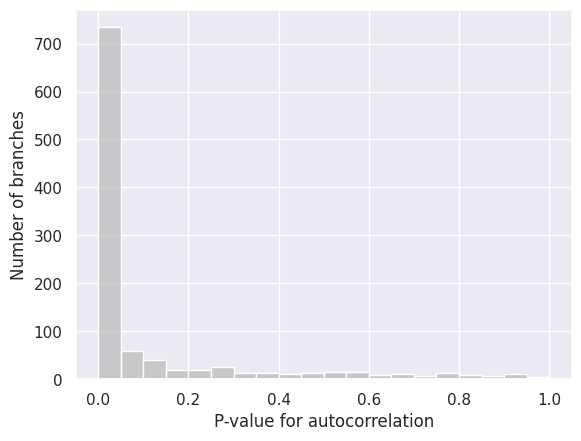

In [12]:
p_values = list(autocorrelation_results_no_nans['p-value'])

from matplotlib import pyplot as plt
import modules.constants as const
from pathlib import Path
import seaborn as sns

output_file = Path(const.DIAGRAM_OUT_PATH) / "autocorrelation_p-values.pdf"

sns.set_theme(style="darkgrid")



fig = plt.figure()
sns.histplot(p_values, binwidth=0.05, color="#bdbdbd")
plt.xlabel("P-value for autocorrelation")
plt.ylabel("Number of branches")

plt.savefig(output_file)
plt.close(fig)

fig

significant: 734
insignificant: 311


<Figure size 640x480 with 0 Axes>

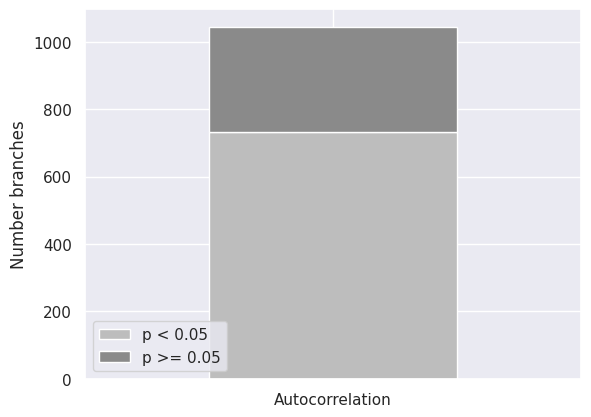

In [13]:
from pandas import DataFrame

p_values_significant = [x for x in p_values if x < 0.05]
p_values_insignificant = [x for x in p_values if x >= 0.05]

assert len(p_values) == len(p_values_significant) + len(p_values_insignificant)

fig = plt.figure()

number_significant = len(p_values_significant)
number_insignificant = len(p_values_insignificant)

barplot_data_dict = {"p < 0.05": [number_significant], "p >= 0.05": [number_insignificant]}
barplot_data_df = DataFrame(barplot_data_dict, index=["Autocorrelation"])

ax = barplot_data_df.plot(kind='bar', stacked=True, color=["#bdbdbd", '#8a8a8a', 'green'])
sns.move_legend(ax, "lower left")
plt.ylabel("Number branches")
plt.xticks(rotation=0)

plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "autocorrelation_p-values_two-bins.pdf")
plt.close(fig)

print("significant: " + str(len(p_values_significant)))
print("insignificant: " + str(len(p_values_insignificant)))

fig

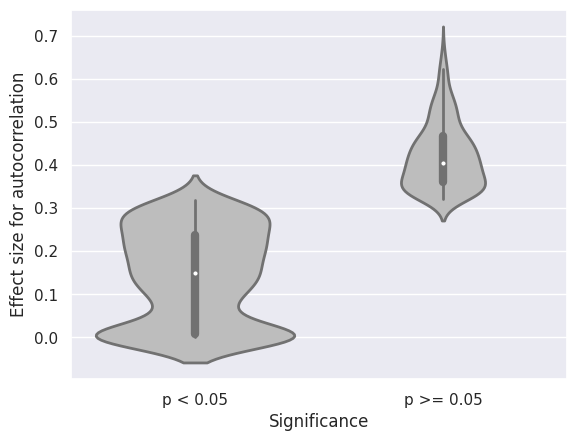

In [14]:
sns.set_theme(style="darkgrid")

x_axis = "Significance"
y_axis = "Effect size for autocorrelation"

list_of_tuples = []
for size in autocorrelation_results_no_nans.query('`p-value` < 0.05')['effect size']:
    list_of_tuples.append(("p < 0.05", size))
for size in autocorrelation_results_no_nans.query('`p-value` >= 0.05')['effect size']:
    list_of_tuples.append(("p >= 0.05", size))

effect_sizes_df = DataFrame(list_of_tuples, columns=[x_axis, y_axis])

fig = plt.figure()
sns.violinplot(data=effect_sizes_df, x=x_axis, y=y_axis, linewidth=2, color="#bdbdbd", order=["p < 0.05", "p >= 0.05"], scale="count")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "autocorrelation_effect_size.pdf")
plt.close(fig)
fig

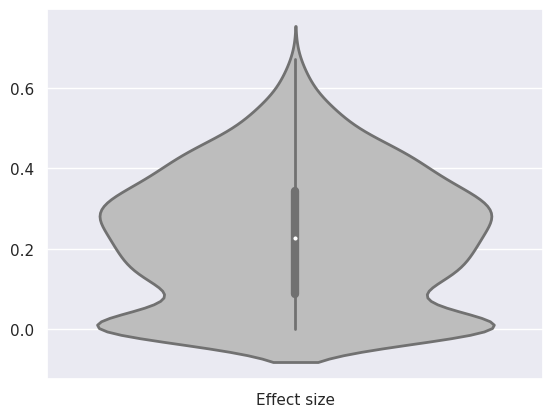

In [15]:
sns.set_theme(style="darkgrid")

effect_size_values_not_none_df = DataFrame(list(autocorrelation_results_no_nans['effect size']), columns=["Effect size"])

fig = plt.figure()
sns.violinplot(data=effect_size_values_not_none_df, linewidth=2, color="#bdbdbd")
plt.savefig(Path(const.DIAGRAM_OUT_PATH) / "autocorrelation_effect-size_aggregated.pdf")
plt.close(fig)
fig

Clearly, code-based fitness generates a lower autocorrelation, if it does not generate flat walks. How can this be reconciled with code-based fitness having lower information content? Well firstly, the flat walks obviously hold no information at all, and have thus a lower information content. The flat walks alone cannot account for all the objectives where code-based has a lower information content though.
This could be explained by the fact that a walk that is almost flat generates both a low autocorrelation and a low information content. This argument again supports our previous argument, stating that the low information content of code-based is due to the high neutrality and not due to smooth gradients.